In [4]:
import numpy as np
import gbspy as g
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scienceplots
plt.style.use(['science','notebook'])
#import scipy.stats as stat
#import scipy.interpolate as interp
#import os
#import f90nml

In [5]:
sim_mag = g.pp.Sim("E:/GBSpy-20250925T081136Z-1-001/GBSpy/ResultsTest/results_1018.h5")

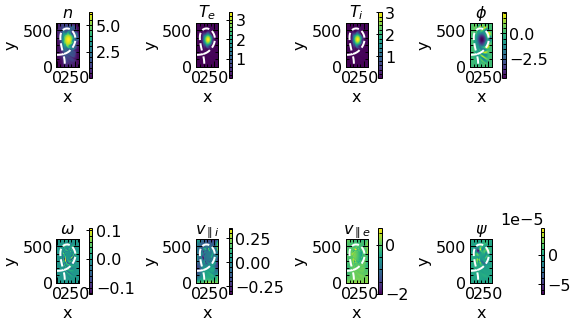

In [6]:
g.plot_all(sim_mag)

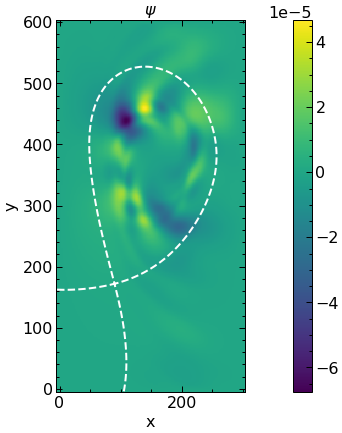

In [7]:
g.plot2d(sim_mag,"psi")

In [8]:
dpsidx_n = sim_mag.dpsidx_n
dpsidy_n = sim_mag.dpsidy_n

In [9]:
B0 = 0.95
rho_star = 1.0 / sim_mag.attribute['rorho_s']

In [10]:
Bx_data = rho_star * dpsidy_n
By_data = -rho_star * dpsidx_n
Bz_data = np.ones_like(Bx_data)

In [11]:
B_magnitude = np.sqrt(Bx_data**2 + By_data**2 + Bz_data**2)

b_hat = np.stack((By_data, Bx_data, Bz_data), axis=-1) / B_magnitude[..., np.newaxis]
b_hat_reshaped = b_hat[..., np.newaxis, :]
b_hat_vector = np.broadcast_to(b_hat_reshaped, (304, 154, 64, 3))


In [12]:
b_hat.shape

(304, 154, 3)

In [13]:
def cross_product_with_b_hat(vector_perp, b_hat_vector):
    # vector_perp has a shape of (304, 154, 64, 2)
    # We must pad it to a 3D vector for the cross product.
    # The `np.zeros_like` call needs to create a vector with a single component.
    # We take a slice of size 1 from the last axis to get the correct shape for zeros.
    vector_perp_3d = np.concatenate([vector_perp, np.zeros_like(vector_perp[..., :1])], axis=-1)

    # Now, vector_perp_3d has a shape of (304, 154, 64, 3).
    # This shape is compatible with b_hat_vector.shape for the element-wise cross product.
    cross_product_result = np.cross(vector_perp_3d, b_hat_vector)
    
    # The result is a 3D vector. We return its perpendicular components.
    return cross_product_result[..., :2]

In [14]:
subsim = g.pp.Sim("Z:")

E:\GBSpy-20250925T081136Z-1-001\GBSpy\python_scripts\gbspy\pp.py:407: UserWarning: Magnetic equilibrium not loaded. Some features may be unavailable.
  warnings.warn(('Magnetic equilibrium not loaded. Some features '


In [15]:
print(len(subsim.time))

3776


In [16]:
sim = subsim.subsample(n=400)

In [17]:
print(len(sim.time))

400


In [18]:
Ek_m_num  = np.zeros((304, 154, 64, 2),dtype = np.float64)
denom = np.zeros((304, 154, 64),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    # --- Load instantaneous 3D data for this time step ---
    n = np.squeeze(sim.get_field("n", t1=sim.time[i], t2=sim.time[i]))
    phi = np.squeeze(sim.get_field("strmf", t1=sim.time[i], t2=sim.time[i]))
    pi = np.squeeze(sim.get_field("pi", t1=sim.time[i], t2=sim.time[i]))
    

    # --- calculation of instantaneous V_E_perp ---
    grad_phi_x = g.grad.gradx_n2n(sim, phi)
    grad_phi_y = g.grad.grady_n2n(sim, phi)
    grad_phi_perp = np.stack((grad_phi_x, grad_phi_y), axis=-1)
    grad_phi_perp_reshaped = np.squeeze(grad_phi_perp)
    vector_perp_3d = np.concatenate([grad_phi_perp_reshaped, np.zeros_like(grad_phi_perp_reshaped[..., :1])], axis=-1)
    cross_product_result = np.cross(vector_perp_3d, b_hat_vector)
    V_E_perp_result = cross_product_result[..., :2]/B_magnitude[:,:,np.newaxis,np.newaxis]

    # --- calculation of instantaneous V_star_i_perp ---
    grad_pi_x = g.grad.gradx_n2n(sim, pi)
    grad_pi_y = g.grad.grady_n2n(sim, pi)
    grad_pi_perp = np.stack((grad_pi_x, grad_pi_y), axis=-1)
    grad_pi_perp_reshaped = np.squeeze(grad_pi_perp)
    vector_perp_3d = np.concatenate([grad_pi_perp_reshaped, np.zeros_like(grad_pi_perp_reshaped[..., :1])], axis=-1)
    cross_product_result = np.cross(vector_perp_3d, b_hat_vector)
    
    # --- [THE FIX is HERE] ---
    # Add a new axis to the denominator to broadcast it
    # from (304, 154, 64) to (304, 154, 64, 1)
    denominator_broadcastable = n[..., np.newaxis]
    V_star_i_perp = cross_product_result[..., :2] / (denominator_broadcastable)

    # --- sum to get V_0_perp ---
    V_0_perp = V_E_perp_result + V_star_i_perp
    
    # --- calculation of E_k_m_perp ---
    # --- [THE FIX is HERE] ---
    # Add a new axis to 'n' to multiply the scalar by the vector
    ntimesV0 = n[..., np.newaxis] * V_0_perp
    
    Ek_m_num = Ek_m_num + ntimesV0
    
    # --- [THE FIX is HERE] ---
    # Add the scalar density 'n' to the 3D 'denom' array
    denom = denom + n

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [7:02:45<00:00, 63.41s/it]


In [20]:
V0_perp_tilde = Ek_m_num / (denom[...,np.newaxis])
np.save('V0_perp_3d.npy',V0_perp_tilde)
V0_perp_tilde_squared = np.sum(V0_perp_tilde**2,axis=-1)
V0_perp_tilde.shape

(304, 154, 64, 2)

In [21]:
n_avg = denom / sim.time.shape[0]
np.save("density.npy",n_avg)
Ek_m_perp = (n_avg * V0_perp_tilde_squared)
np.save('Ek_m_perp.npy',Ek_m_perp)

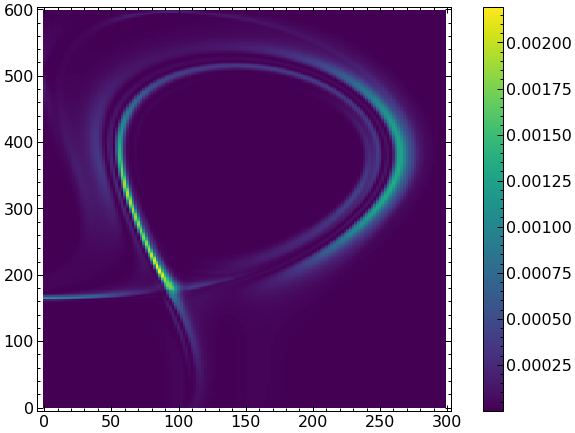

<Figure size 576x432 with 0 Axes>

In [18]:
Ek_perp_plane = np.mean(Ek_m_perp,axis=-1)
g.plotf2d(Ek_perp_plane,sim.x,sim.y)
plt.savefig('Ek_m_perp.png')

In [20]:
Ek = np.zeros((304, 154, 64),dtype = np.float64)
k_num  = np.zeros((304, 154, 64),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    #calculation of instantaneous V_E_perp
    n = np.squeeze(sim.get_field("n",t1=sim.time[i],t2=sim.time[i]))
    phi = np.squeeze(sim.get_field("strmf",t1=sim.time[i],t2=sim.time[i]))
    grad_phi_x = g.grad.gradx_n2n(sim, phi)
    grad_phi_y = g.grad.grady_n2n(sim, phi)
    grad_phi_perp = np.stack((grad_phi_x, grad_phi_y), axis=-1)
    grad_phi_perp_reshaped = np.squeeze(grad_phi_perp)
    vector_perp_3d = np.concatenate([grad_phi_perp_reshaped, np.zeros_like(grad_phi_perp_reshaped[..., :1])], axis=-1)
    cross_product_result = np.cross(vector_perp_3d, b_hat_vector)
    V_E_perp_result = cross_product_result[..., :2]/B_magnitude[:,:,np.newaxis,np.newaxis]
    #calculation of instantaneous V_star_i_perp
    pi = sim.get_field("pi",t1=sim.time[i],t2=sim.time[i])
    grad_pi_x = g.grad.gradx_n2n(sim, pi)
    grad_pi_y = g.grad.grady_n2n(sim, pi)
    grad_pi_perp = np.stack((grad_pi_x, grad_pi_y), axis=-1)
    grad_pi_perp_reshaped = np.squeeze(grad_pi_perp)
    vector_perp_3d = np.concatenate([grad_pi_perp_reshaped, np.zeros_like(grad_pi_perp_reshaped[..., :1])], axis=-1)
    cross_product_result = np.cross(vector_perp_3d, b_hat_vector)
    denominator_broadcastable = n[..., np.newaxis]
    V_star_i_perp = cross_product_result[..., :2] / (denominator_broadcastable)
    #sum to get V_0_perp
    V_0_perp = V_E_perp_result + V_star_i_perp
    #calculation of Ek
    V_sq = np.sum(V_0_perp**2,axis=-1)
    Ek = Ek+n*V_sq
    #calculation of k_perp
    V_double_prime_sq = np.sum((V_0_perp - V0_perp_tilde)**2,axis=-1)
    k_num = k_num+n*V_double_prime_sq

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [4:03:45<00:00, 36.56s/it]


In [21]:
k_perp = k_num/(denom)
np.save('k_perp.npy',k_perp)

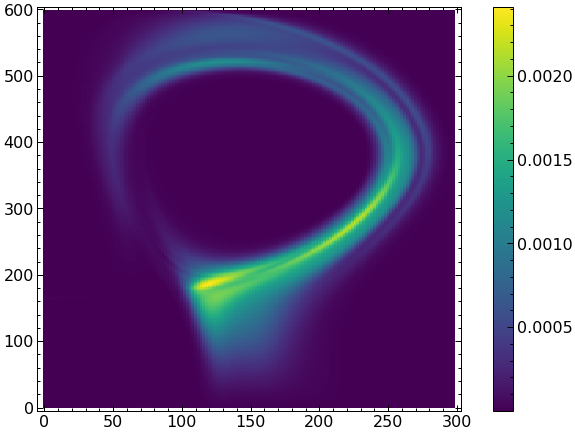

<Figure size 576x432 with 0 Axes>

In [22]:
Ek_perp_plane = np.mean(k_perp,axis=-1)
g.plotf2d(Ek_perp_plane,sim.x,sim.y)
plt.savefig('k_perp.png')

In [23]:
avg = Ek/(sim.time.shape[0])
diff = avg - (denom*(k_perp/sim.time.shape[0]))-Ek_m_perp
np.save('diff.npy',diff)

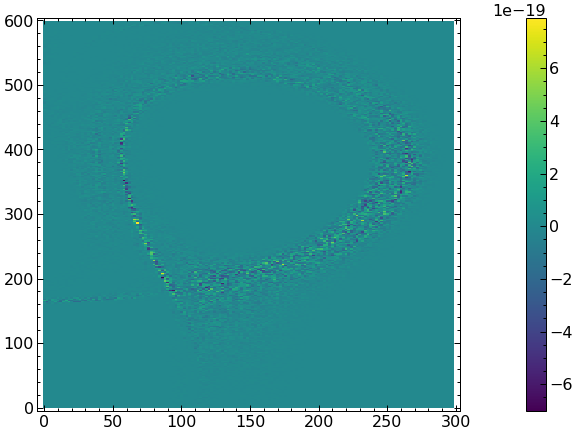

<Figure size 576x432 with 0 Axes>

In [24]:
Ek_perp_plane = np.mean(diff,axis=-1)
g.plotf2d(Ek_perp_plane,sim.x,sim.y)
plt.savefig('error.png')

In [15]:
Eke_m_num  = np.zeros((304, 154, 64, 2),dtype = np.float64)
temp = np.zeros((304,154,64),dtype=np.float64)
Ve = np.zeros((304, 154, 64, 2),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    #calculation of instantaneous V_E_perp
    n = np.squeeze(sim.get_field("n",t1=sim.time[i],t2=sim.time[i]))
    phi = np.squeeze(sim.get_field("strmf",t1=sim.time[i],t2=sim.time[i]))
    ti = np.squeeze(sim.get_field("Ti", t1=sim.time[i], t2=sim.time[i]))
    te = np.squeeze(sim.get_field("Te", t1=sim.time[i], t2=sim.time[i]))
    temp = n*(ti+te)+temp
    grad_phi_x = g.grad.gradx_n2n(sim, phi)
    grad_phi_y = g.grad.grady_n2n(sim, phi)
    grad_phi_perp = np.stack((grad_phi_x, grad_phi_y), axis=-1)
    grad_phi_perp_reshaped = np.squeeze(grad_phi_perp)
    vector_perp_3d = np.concatenate([grad_phi_perp_reshaped, np.zeros_like(grad_phi_perp_reshaped[..., :1])], axis=-1)
    cross_product_result = np.cross(vector_perp_3d, b_hat_vector)
    V_E_perp_result = cross_product_result[..., :2]/B_magnitude[:,:,np.newaxis,np.newaxis]
    V_0_perp = V_E_perp_result
    Ve = Ve+V_0_perp
    #calculation of E_k_m_perp
    ntimesV0 = n[...,np.newaxis]*V_0_perp
    Eke_m_num = Eke_m_num+ntimesV0

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [4:04:07<00:00, 36.62s/it]


In [18]:
denom = np.load('density.npy')*sim.time.shape[0]

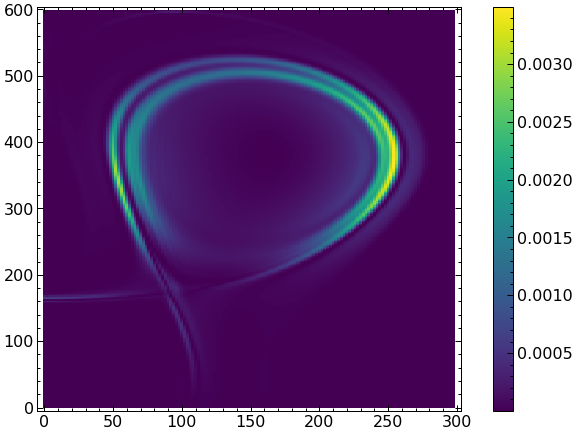

<Figure size 576x432 with 0 Axes>

In [20]:
Ve_perp_tilde = Eke_m_num / denom[...,np.newaxis]
np.save('Ve_tilde_3d.npy',Ve_perp_tilde)
t_avg = temp/sim.time.shape[0]
np.save('t_avg.npy',t_avg)
Ve_mean = Ve/sim.time.shape[0]
np.save('ve_mean.npy',Ve_mean)
Ve_perp_tilde_squared =np.sum(Ve_perp_tilde**2,axis=-1)
Eke_m_perp = (denom/sim.time.shape[0]) * Ve_perp_tilde_squared
np.save('Eke_m_perp.npy',np.mean(Eke_m_perp,axis=-1))
Ek_perp_plane = np.mean(Eke_m_perp,axis=-1)
g.plotf2d(Ek_perp_plane,sim.x,sim.y)
plt.savefig('Eke_m_perp.png')

In [26]:
Ek_e = np.zeros((304, 154, 64),dtype = np.float64)
ke_num  = np.zeros((304, 154, 64),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    #calculation of instantaneous V_E_perp
    n = np.squeeze(sim.get_field("n",t1=sim.time[i],t2=sim.time[i]))
    phi = np.squeeze(sim.get_field("strmf",t1=sim.time[i],t2=sim.time[i]))
    grad_phi_x = g.grad.gradx_n2n(sim, phi)
    grad_phi_y = g.grad.grady_n2n(sim, phi)
    grad_phi_perp = np.stack((grad_phi_x, grad_phi_y), axis=-1)
    grad_phi_perp_reshaped = np.squeeze(grad_phi_perp)
    vector_perp_3d = np.concatenate([grad_phi_perp_reshaped, np.zeros_like(grad_phi_perp_reshaped[..., :1])], axis=-1)
    cross_product_result = np.cross(vector_perp_3d, b_hat_vector)
    V_E_perp_result = cross_product_result[..., :2]/B_magnitude[:,:,np.newaxis,np.newaxis]
    #sum to get V_0_perp
    V_0_perp = V_E_perp_result
    #calculation of Ek
    V_sq = np.sum(V_0_perp**2,axis=-1)
    Ek_e = Ek_e+n*V_sq
    #calculation of k_perp
    V_double_prime_sq = np.sum((V_0_perp - Ve_perp_tilde)**2,axis=-1)
    ke_num = ke_num+n*V_double_prime_sq

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [2:26:11<00:00, 21.93s/it]


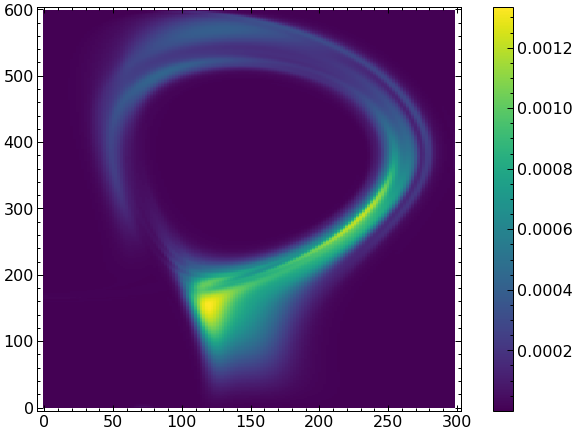

<Figure size 576x432 with 0 Axes>

In [108]:
ke_perp =ke_num/(denom)
Ek_perp_plane = np.mean(ke_perp,axis=-1)
np.save('ke_perp.npy',Ek_perp_plane)
g.plotf2d(Ek_perp_plane,sim.x,sim.y)
plt.savefig('ke_perp.png')

In [109]:
avg = Ek_e/(sim.time.shape[0])
diff = np.mean((avg - (denom*(ke_perp/sim.time.shape[0]))-Eke_m_perp),axis=-1)
np.save('diff_e.npy',diff)

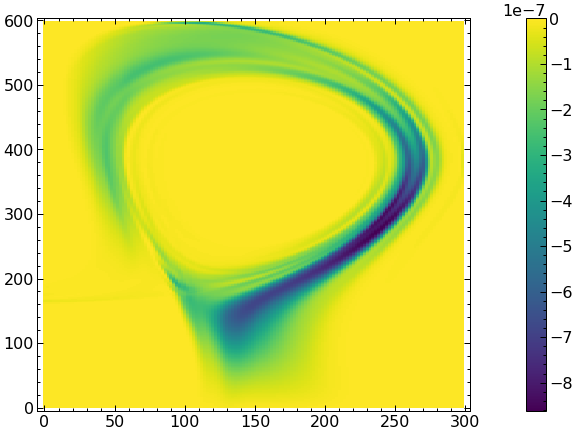

<Figure size 576x432 with 0 Axes>

In [110]:
Ek_perp_plane = diff
g.plotf2d(Ek_perp_plane,sim.x,sim.y)
plt.savefig('error_e.png')

In [94]:
phi_sum = np.zeros((304, 154, 64),dtype = np.float64)
j_par_sum = np.zeros((304, 154, 64),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    phi = np.squeeze(sim.get_field("strmf",t1=sim.time[i],t2=sim.time[i]))
    jpar = np.squeeze(sim.get_field("jpar",t1=sim.time[i],t2=sim.time[i]))
    phi_sum = phi_sum+phi
    j_par_sum = j_par_sum+jpar

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [4:41:01<00:00, 42.15s/it]


In [95]:
phi_mean = np.mean(phi_sum/(sim.time.shape[0]),axis=-1)
jpar_mean = np.mean(j_par_sum/(sim.time.shape[0]),axis=-1)
np.save('phi_mean.npy',phi_mean)
np.save('jpar_mean.npy',jpar_mean)
jpar_mean.shape

(304, 154)

In [96]:
flux_scalar_sum = np.zeros((304, 154, 64),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    phi = np.squeeze(sim.get_field("strmf",t1=sim.time[i],t2=sim.time[i]))
    jpar = np.squeeze(sim.get_field("jpar",t1=sim.time[i],t2=sim.time[i]))
    phi_prime = phi-phi_mean[:, :, np.newaxis]
    jpar_prime = jpar-jpar_mean[:, :, np.newaxis]
    flux_scalar_sum = flux_scalar_sum+phi_prime*jpar_prime

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [4:22:11<00:00, 39.33s/it]


In [97]:
grad_flux = np.squeeze(g.grad.gradpar_n2n(sim_mag,flux_scalar_sum[...,np.newaxis]/sim.time.shape[0]))

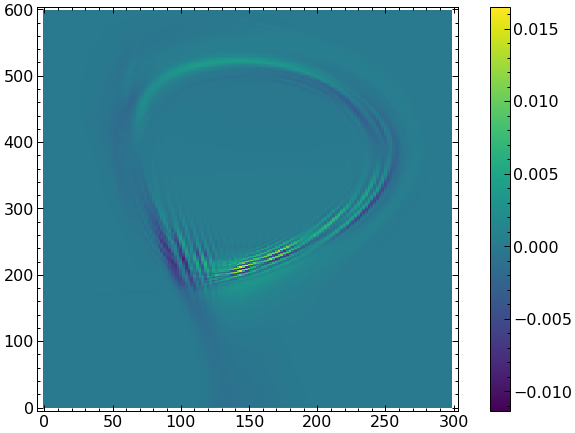

<Figure size 576x432 with 0 Axes>

In [98]:
Ek_perp_plane = np.mean(grad_flux,axis=-1)
np.save('grad_flux.npy',Ek_perp_plane)
g.plotf2d(Ek_perp_plane,sim.x,sim.y)
plt.savefig('grad_flux.png')

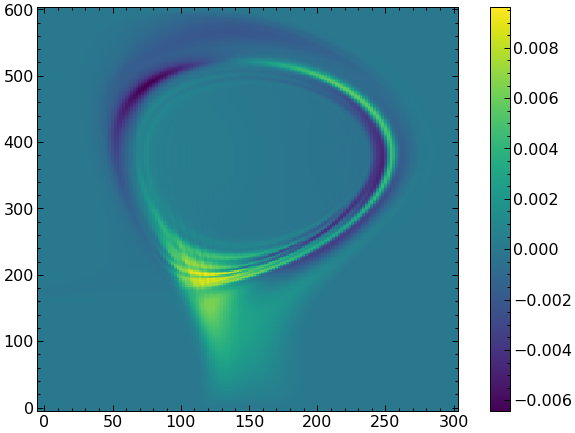

<Figure size 576x432 with 0 Axes>

In [99]:
flux = np.mean(flux_scalar_sum,axis=-1)/sim.time.shape[0]
np.save('flux.npy',flux)
g.plotf2d(flux,sim.x,sim.y)
plt.savefig('flux.png')

In [ ]:
drift_wave = np.zeros((304, 154, 64, 1),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    phi = np.squeeze(sim.get_field("strmf",t1=sim.time[i],t2=sim.time[i]))
    jpar = np.squeeze(sim.get_field("jpar",t1=sim.time[i],t2=sim.time[i]))
    phi_prime = phi-phi_mean[:, :, np.newaxis]
    grad_phi_prime = g.grad.gradpar_n2n(sim_mag,phi_prime[...,np.newaxis])
    jpar_prime = jpar-jpar_mean[:, :, np.newaxis]
    drift_wave = drift_wave+grad_phi_prime*jpar_prime[...,np.newaxis]

In [ ]:
drift_wave_mean = np.squeeze(drift_wave/sim.time.shape[0],axis=-1)

In [ ]:
drift_wave_mean.shape

In [ ]:
Ek_perp_plane = np.mean(drift_wave_mean,axis=-1)
np.save('drift_wave.npy',Ek_perp_plane)
g.plotf2d(Ek_perp_plane,sim.x,sim.y)
plt.savefig('drift_wave.png')

In [21]:
p_sum = np.zeros((304, 154, 64),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    pi = np.squeeze(sim.get_field("pi",t1=sim.time[i],t2=sim.time[i]))
    pe = np.squeeze(sim.get_field("pe",t1=sim.time[i],t2=sim.time[i]))
    p_sum = p_sum+pi+pe

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [3:58:13<00:00, 35.73s/it]


In [46]:
p_mean = np.mean(p_sum/sim.time.shape[0],axis=-1)
np.save('p_mean.npy',p_mean)
Ve_mean  = np.load('ve_mean.npy')

In [28]:
p_div_v_sum = np.zeros((304, 154, 64),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    phi = np.squeeze(sim.get_field("strmf",t1=sim.time[i],t2=sim.time[i]))
    grad_phi_x = g.grad.gradx_n2n(sim, phi)
    grad_phi_y = g.grad.grady_n2n(sim, phi)
    grad_phi_perp = np.stack((grad_phi_x, grad_phi_y), axis=-1)
    grad_phi_perp_reshaped = np.squeeze(grad_phi_perp)
    vector_perp_3d = np.concatenate([grad_phi_perp_reshaped, np.zeros_like(grad_phi_perp_reshaped[..., :1])], axis=-1)
    cross_product_result = np.cross(vector_perp_3d, b_hat_vector)
    V_E_perp_result = cross_product_result[..., :2]/B_magnitude[:,:,np.newaxis,np.newaxis]
    V_E_x = V_E_perp_result[..., 0]
    V_E_y = V_E_perp_result[..., 1]
    grad_Vx_x = g.grad.gradx_n2n(sim, V_E_x - Ve_mean[...,0])
    grad_Vy_y = g.grad.grady_n2n(sim, V_E_y-Ve_mean[...,1])
    div_v_prime = grad_Vx_x + grad_Vy_y
    pi = np.squeeze(sim.get_field("pi",t1=sim.time[i],t2=sim.time[i]))
    pe = np.squeeze(sim.get_field("pe",t1=sim.time[i],t2=sim.time[i]))
    p_prime = pi+pe-p_mean[:, :, np.newaxis]
    p_div_v_sum = p_div_v_sum + p_prime*div_v_prime

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [5:04:47<00:00, 45.72s/it]


In [29]:
p_div_v_mean = p_div_v_sum/sim.time.shape[0]

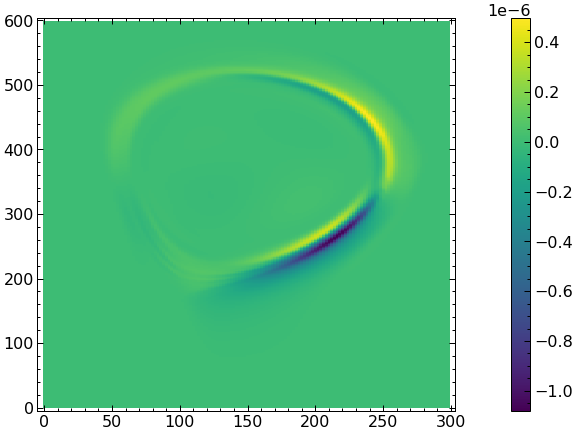

<Figure size 576x432 with 0 Axes>

In [30]:
Ek_perp_plane = np.mean(p_div_v_mean,axis=-1)
np.save('p_div_v.npy',Ek_perp_plane)
g.plotf2d(Ek_perp_plane,sim.x,sim.y)
plt.savefig('p_div_v.png')

In [32]:
Ve_tilde = np.load('Ve_tilde_3d.npy')

In [34]:
term3x = np.zeros((304, 154, 64),dtype = np.float64)
term3y = np.zeros((304, 154, 64),dtype = np.float64)
term4x = np.zeros((304, 154, 64),dtype = np.float64)
term4y = np.zeros((304, 154, 64),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    n = np.squeeze(sim.get_field("n", t1=sim.time[i], t2=sim.time[i]))
    phi = np.squeeze(sim.get_field("strmf", t1=sim.time[i], t2=sim.time[i]))
    ti = np.squeeze(sim.get_field("Ti", t1=sim.time[i], t2=sim.time[i]))
    te = np.squeeze(sim.get_field("Te", t1=sim.time[i], t2=sim.time[i]))
    grad_phi_x = g.grad.gradx_n2n(sim, phi)
    grad_phi_y = g.grad.grady_n2n(sim, phi)
    grad_phi_perp = np.stack((grad_phi_x, grad_phi_y), axis=-1)
    grad_phi_perp_reshaped = np.squeeze(grad_phi_perp)
    vector_perp_3d = np.concatenate([grad_phi_perp_reshaped, np.zeros_like(grad_phi_perp_reshaped[..., :1])], axis=-1)
    cross_product_result = np.cross(vector_perp_3d, b_hat_vector)
    V_E_perp_result = cross_product_result[..., :2]/B_magnitude[:,:,np.newaxis,np.newaxis]
    V_E_xp = V_E_perp_result[..., 0]-Ve_mean[...,0]
    V_E_yp = V_E_perp_result[..., 1]-Ve_mean[...,1]
    V_E_xdp = V_E_perp_result[..., 0]-Ve_tilde[...,0]
    V_E_ydp = V_E_perp_result[..., 1]-Ve_tilde[...,1]
    term3x = term3x - (n-denom/sim.time.shape[0])*V_E_xp
    term3y = term3y - (n-denom/sim.time.shape[0])*V_E_yp
    term4x = term4x - n*(ti+te-t_avg)*V_E_xdp
    term4y = term4y - n*(ti+te-t_avg)*V_E_ydp

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [4:31:00<00:00, 40.65s/it]


In [35]:
pdiv_v_re = ((term3x*t_avg + term4x)*g.grad.gradx_n2n(sim,np.log(B_magnitude[...,np.newaxis]**2))) + ((term3y*t_avg + term4y)*g.grad.grady_n2n(sim,np.log(B_magnitude[...,np.newaxis]**2)))
np.save('pdiv_v_re.npy',pdiv_v_re)

In [48]:
phi_mean = np.load('phi_mean.npy')
term5 = np.zeros((304, 154, 64),dtype = np.float64)
for i in tqdm(range(sim.time.shape[0])):
    phi = np.squeeze(sim.get_field("strmf", t1=sim.time[i], t2=sim.time[i]))
    phi_p = phi-phi_mean[...,np.newaxis]
    pi = np.squeeze(sim.get_field("pi",t1=sim.time[i],t2=sim.time[i]))
    pe = np.squeeze(sim.get_field("pe",t1=sim.time[i],t2=sim.time[i]))
    p_prime = pi+pe-p_mean[...,np.newaxis]
    curve_p = g.curv_n2n(sim,p_prime)
    term5 = term5 + phi_p*curve_p

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [6:22:03<00:00, 57.31s/it]


In [49]:
pdiv_v_an = 2*term5/sim.time.shape[0]
np.save('pdiv_v_an.npy',pdiv_v_an)

In [ ]:
def calculate_J_p_star(sim_obj, n, phi, pi, B_mag, b_hat):
    """
    Calculates the instantaneous J_p_star vector based on your definition:
    J_p,* = (1/B) * div(n * V_E * U_*,i)
    All inputs are 3D numpy arrays.
    """
    
    # 1. Calculate V_E (vector)
    grad_phi_x = g.grad.gradx_n2n(sim_obj, phi)
    grad_phi_y = g.grad.grady_n2n(sim_obj, phi)
    grad_phi_perp = np.stack((grad_phi_x, grad_phi_y), axis=-1)
    grad_phi_perp_reshaped = np.squeeze(grad_phi_perp)
    vector_perp_3d = np.concatenate([grad_phi_perp_reshaped, np.zeros_like(grad_phi_perp_reshaped[..., :1])], axis=-1)
    cross_product_result = np.cross(vector_perp_3d, b_hat)
    V_E = cross_product_result[..., :2]/B_magnitude[:,:,np.newaxis,np.newaxis]
    
    # 2. Calculate U_*,i (vector)
    grad_pi_x = g.grad.gradx_n2n(sim_obj, pi)
    grad_pi_y = g.grad.grady_n2n(sim_obj, pi)
    grad_pi_perp = np.stack((grad_pi_x, grad_pi_y), axis=-1)
    
    n_broadcastable = n[..., np.newaxis] + 1e-15
    B_mag_broadcastable = B_mag[..., np.newaxis] + 1e-15
    U_star_i = grad_pi_perp / (n_broadcastable)

    # 3. Calculate tensor components F_jk = n * V_E_j * U_*,i_k
    n_V_E_x = n * V_E[..., 0]
    n_V_E_y = n * V_E[..., 1]
    
    F_xx = n_V_E_x * U_star_i[..., 0]
    F_xy = n_V_E_x * U_star_i[..., 1]
    F_yx = n_V_E_y * U_star_i[..., 0]
    F_yy = n_V_E_y * U_star_i[..., 1]

    # 4. Calculate divergence of the tensor (results in a vector)
    div_F_x = g.grad.gradx_n2n(sim_obj, F_xx) + g.grad.grady_n2n(sim_obj, F_yx)
    div_F_y = g.grad.gradx_n2n(sim_obj, F_xy) + g.grad.grady_n2n(sim_obj, F_yy)
    
    div_F = np.stack((div_F_x, div_F_y), axis=-1)

    # 5. Final J_p_star vector
    J_p_star = div_F/(B0**2)
    return J_p_star

In [ ]:
N_time = sim.time.shape[0]
nx, ny, nz = 304, 154, 64

In [ ]:
J_p_star_sum = np.zeros((nx, ny, nz, 2), dtype=np.float64)
grad_phi_sum = np.zeros((nx, ny, nz, 2), dtype=np.float64)
phi_sum = np.zeros((nx, ny, nz), dtype=np.float64)

print("Starting Loop 1: Calculating Mean Fields...")
for i in tqdm(range(N_time), desc="Loop 1: Means"):
    n = np.squeeze(sim.get_field("n", t1=sim.time[i], t2=sim.time[i]))
    phi = np.squeeze(sim.get_field("strmf", t1=sim.time[i], t2=sim.time[i]))
    pi = np.squeeze(sim.get_field("pi", t1=sim.time[i], t2=sim.time[i]))
    
    # Calculate instantaneous J_p_star
    J_p_star_inst = calculate_J_p_star(sim_mag, n, phi, pi, B_magnitude, b_hat_vector)
    J_p_star_sum += J_p_star_inst
    
    # Calculate instantaneous grad_phi
    grad_phi_x = g.grad.gradx_n2n(sim_mag, phi)
    grad_phi_y = g.grad.grady_n2n(sim_mag, phi)
    grad_phi_sum += np.stack((grad_phi_x, grad_phi_y), axis=-1)
    
    # Accumulate phi
    phi_sum += phi

# Finalize the mean fields
J_p_star_mean = np.mean(J_p_star_sum / N_time,axis=-1)
grad_phi_mean = np.mean(grad_phi_sum / N_time,axis=-1)
phi_mean = np.mean(phi_sum / N_time,axis=-1)

print("Loop 1 complete. Mean fields calculated.")

In [ ]:
term1_sum = np.zeros((nx, ny, nz), dtype=np.float64)

# Term 2: avg(phi' * J_p_star')       (Vector)
term2_sum = np.zeros((nx, ny, nz, 2), dtype=np.float64)

print("Starting Loop 2: Calculating Fluctuation Products...")
for i in tqdm(range(N_time), desc="Loop 2: Fluctuations"):
    n = np.squeeze(sim.get_field("n", t1=sim.time[i], t2=sim.time[i]))
    phi = np.squeeze(sim.get_field("strmf", t1=sim.time[i], t2=sim.time[i]))
    pi = np.squeeze(sim.get_field("pi", t1=sim.time[i], t2=sim.time[i]))
    
    # Calculate instantaneous J_p_star and grad_phi
    J_p_star_inst = calculate_J_p_star(sim_mag, n, phi, pi, B_magnitude, b_hat_vector)
    grad_phi_x_inst = g.grad.gradx_n2n(sim_mag, phi)
    grad_phi_y_inst = g.grad.grady_n2n(sim_mag, phi)
    grad_phi_inst = np.stack((grad_phi_x_inst, grad_phi_y_inst), axis=-1)
    
    # Calculate fluctuations
    phi_prime = phi - phi_mean[:, :, np.newaxis]
    grad_phi_prime = grad_phi_inst - grad_phi_mean[:, :,:, np.newaxis]
    J_p_star_prime = J_p_star_inst - J_p_star_mean[:, :,:, np.newaxis]
    
    # --- Term 1: avg(grad_phi' . J_p_star') ---
    dot_product = np.sum(grad_phi_prime * J_p_star_prime, axis=-1)
    term1_sum += dot_product
    
    # --- Term 2: avg(phi' * J_p_star') ---
    # Use broadcasting for scalar * vector
    inst_flux_vector = phi_prime[..., np.newaxis] * J_p_star_prime
    term2_sum += inst_flux_vector

# Finalize the averages
term1_result = np.mean(term1_sum / N_time,axis=-1)
term2_mean_flux = term2_sum / N_time

print("Loop 2 complete.")

In [ ]:
print("Calculating final divergence for Term 2...")

# Calculate div(term2_mean_flux) = d_x(Fx) + d_y(Fy)
mean_flux_x = term2_mean_flux[..., 0]
mean_flux_y = term2_mean_flux[..., 1]

div_x = g.grad.gradx_n2n(sim_mag, mean_flux_x)
div_y = g.grad.grady_n2n(sim_mag, mean_flux_y)

term2_result = np.mean(div_x + div_y,axis=-1)

print("All calculations complete.")
print(f"Term 1 (avg(grad_phi' . J_p_star')) shape: {term1_result.shape}")
print(f"Term 2 (div(avg(phi' * J_p_star'))) shape: {term2_result.shape}")

In [18]:
p_div_v = np.load('p_div_v.npy')
drift_wave = np.load('drift_wave.npy')
grad_flux = np.load('grad_flux.npy')
ke_perp = np.load('ke_perp.npy')
n = np.load('density.npy')
pdiv_v_curve = np.load('pdiv_v_an.npy')
pdiv_v_temp = np.load('pdiv_v_re.npy')
diff = np.load('diff.npy')
diff_e = np.load('diff_e.npy')
ek_e_mean = np.load('Eke_m_perp.npy')
ek_m_perp = np.load('Ek_m_perp.npy')
k_perp = np.load('k_perp.npy')

In [19]:
drift_wave.shape

(304, 154)

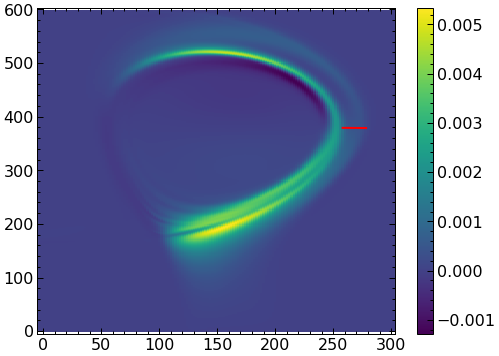

In [123]:
plt.figure()
plt.pcolormesh(sim_mag.x,sim_mag.y,-1*np.mean(pdiv_v_curve,axis=-1))
plt.colorbar()
#plt.contour(sim_mag.x,sim_mag.y,sim_mag.Psi,levels = [sim_mag.Psi[sim_mag.iyxpt,sim_mag.ixxpt]],colors = 'r')
plt.plot(X_new[:,118],Y_new[:,118],color = 'r')
plt.savefig("interchange_lfs.jpg")
plt.show()

In [21]:
total_absolute_error = np.nansum(np.abs(diff_e))

# 2. Calculate the Total Energy in the system (Sum of energy)
total_energy_sum = np.nansum(np.abs(ek_e_mean))

# 3. Compute Relative Error
epsilon = total_absolute_error / total_energy_sum

print(f"Global Relative Error: {epsilon}")

Global Relative Error: 0.0003973609502961575


In [22]:
from scipy.interpolate import griddata

In [84]:
X_orig, Y_orig = np.meshgrid(sim_mag.x, sim_mag.y)
X_new, Y_new, rpsi_coord, chi_coord = g.build_grid(sim_mag, rmin=1, rmax=2)
radial_axis_for_plot = rpsi_coord

E:\GBSpy-20250925T081136Z-1-001\GBSpy\python_scripts\gbspy\grid.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if (np.asarray(segs).ndim == 2):


rmax set to  1.225482924120328


In [85]:
chi_coord.shape

(41, 192)

In [141]:
def get_1d_radial_profile(term_2d_data):
    # 1. Toroidally average the 3D data to 2D

    # 2. Interpolate the 2D data onto the flux-aligned (r, chi) grid
    term_on_flux_grid = griddata(
        (X_orig.ravel(), Y_orig.ravel()),
        term_2d_data.ravel(),
        (X_new, Y_new),
        method='linear'
    )
    
    # 3. Flux-surface average (average along chi) to get 1D radial profile
    chi_axis_1d = rpsi_coord

# Find index closest to 0 (LFS)
    idx_lfs = np.argmin(np.abs(chi_axis_1d - 1))

# Find index closest to 0.5 (HFS)
    #idx_hfs = np.argmin(np.abs(chi_axis_1d - 1.15))

# --- 4. Extract the Radial Profiles ---
# We slice the grid at these specific indices
# Assuming k_e_grid is (N_chi, N_rad)
    profile_lfs = np.mean(term_on_flux_grid[:,150:160],axis=-1)
    return profile_lfs

In [142]:
imbalance_term =  -1*grad_flux - np.mean(pdiv_v_curve,axis=-1) +drift_wave

In [143]:
profile_p_div_v = get_1d_radial_profile(np.mean(pdiv_v_curve,axis=-1))
profile_drift_wave = get_1d_radial_profile(drift_wave)
profile_grad_flux = get_1d_radial_profile(grad_flux)
profile_ke_perp = get_1d_radial_profile(ke_perp)
profile_imbalance_term = get_1d_radial_profile(imbalance_term)

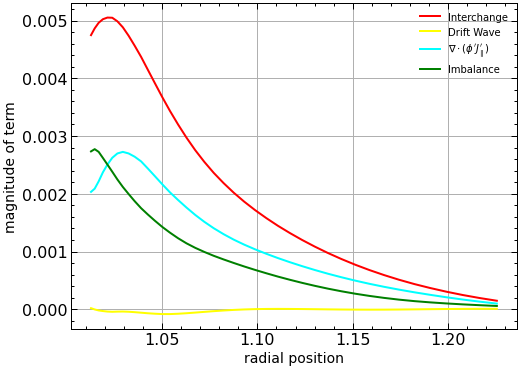

In [144]:
plt.plot(radial_axis_for_plot, -1*profile_p_div_v, label='Interchange', color='red', linewidth=2)
plt.plot(radial_axis_for_plot, profile_drift_wave, label='Drift Wave', color='yellow', linewidth=2)
plt.plot(radial_axis_for_plot, profile_grad_flux, label='$\\nabla \\cdot (\\phi\'J_{\parallel}\') $', color='cyan', linewidth=2)
#plt.plot(radial_axis_for_plot, profile_ke_perp, label='ke_perp', color='green', linewidth=2)
plt.plot(radial_axis_for_plot, profile_imbalance_term, label='Imbalance', color='green', linewidth=2) # Example of 'unbalance'
plt.xlabel('radial position', fontsize=14)
plt.ylabel('magnitude of term', fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.savefig('radial_balance_peak.jpg')# Ensure legend is visible
plt.show()

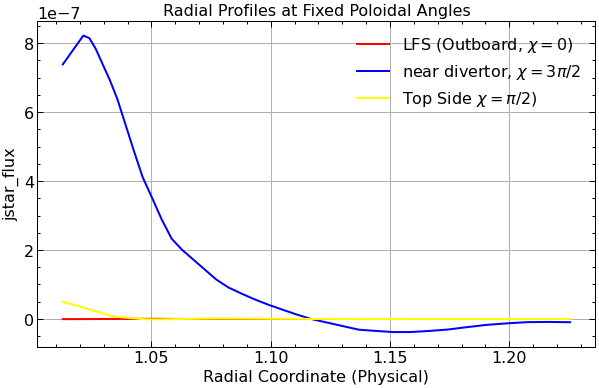

In [40]:
term_mean_2d = jstar_flux
term_on_flux_grid = griddata(
        (X_orig.ravel(), Y_orig.ravel()),
        term_mean_2d.ravel(),
        (X_new, Y_new),
        method='linear'
    )
# The 1D poloidal axis (for finding indices)
chi_axis_1d = chi_coord[0] if chi_coord.ndim > 1 else chi_coord

# Find index closest to 0 (LFS)
idx_lfs = np.argmin(np.abs(chi_axis_1d - 0.0))

# Find index closest to 0.5 (HFS)
idx_hfs = np.argmin(np.abs(chi_axis_1d - 0.75))
idx_top = np.argmin(np.abs(chi_axis_1d - 0.25))
# --- 4. Extract the Radial Profiles ---
# We slice the grid at these specific indices
# Assuming k_e_grid is (N_chi, N_rad)
profile_lfs = term_on_flux_grid[:,idx_lfs]
profile_hfs = term_on_flux_grid[:,idx_hfs]
profile_top = term_on_flux_grid[:,idx_top]
# --- 5. Plot ---
plt.figure(figsize=(10, 6))

plt.plot(rpsi_coord, profile_lfs, label='LFS (Outboard, $\\chi=0$)', color='red', linewidth=2)
plt.plot(rpsi_coord, profile_hfs, label='near divertor, $\\chi=3\\pi /2$', color='blue', linewidth=2)
plt.plot(rpsi_coord, profile_top, label='Top Side $\\chi=\\pi /2$)', color='yellow', linewidth=2)

plt.xlabel('Radial Coordinate (Physical)')
plt.ylabel('jstar_flux')
plt.title('Radial Profiles at Fixed Poloidal Angles')
plt.legend()
plt.grid(True)
plt.show()

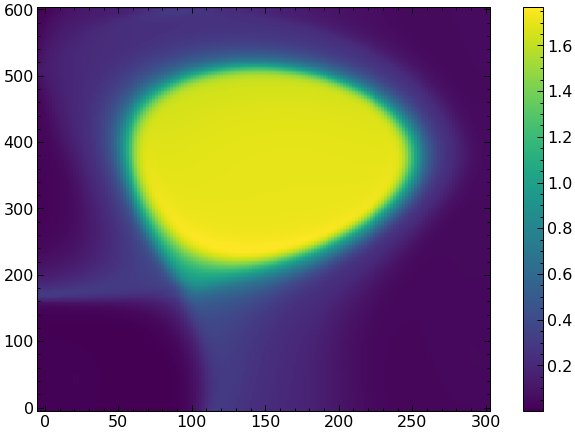

In [29]:
g.plotf2d(np.mean(n,axis=-1),sim.x,sim.y)

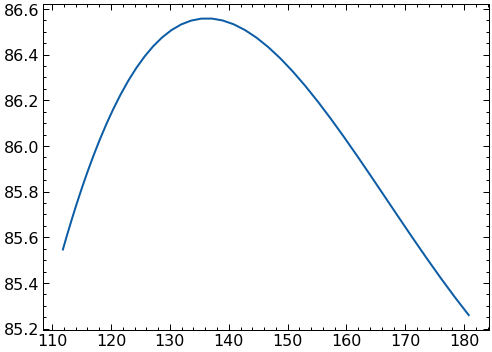

In [70]:
plt.figure()
plt.plot(X_new[:,180],Y_new[:,180])

In [120]:
ir = np.argmin(abs(rpsi_coord-1))
ichi = np.argmin(abs(Y_new[ir,:] - sim_mag.y0))
chi_coord[ir,ichi]

0.6230420242759861

In [121]:
ichi = np.argmin(abs(chi_coord[0]-0.62))
ichi

118

In [27]:
diff = np.load('diff.npy')

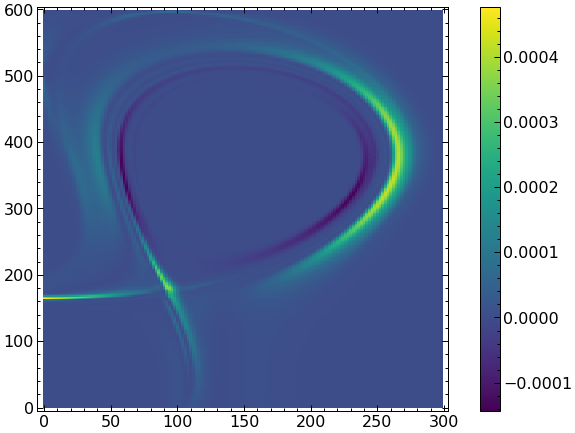

In [28]:
g.plotf2d(diff,sim.x,sim.y)

In [29]:
term_mean_2d = ke_perp
term_on_flux_grid = griddata(
        (X_orig.ravel(), Y_orig.ravel()),
        term_mean_2d.ravel(),
        (X_new, Y_new),
        method='linear'
    )
# The 1D poloidal axis (for finding indices)
chi_axis_1d = chi_coord[0] if chi_coord.ndim > 1 else chi_coord

# Find index closest to 0 (LFS)
idx_lfs = np.argmin(np.abs(chi_axis_1d - 0.0))

# Find index closest to 0.5 (HFS)
idx_hfs = np.argmin(np.abs(chi_axis_1d - 0.75))

# --- 4. Extract the Radial Profiles ---
# We slice the grid at these specific indices
# Assuming k_e_grid is (N_chi, N_rad)
ke_profile_lfs = term_on_flux_grid[:,idx_lfs]

In [30]:
term_mean_2d = diff
term_on_flux_grid = griddata(
        (X_orig.ravel(), Y_orig.ravel()),
        term_mean_2d.ravel(),
        (X_new, Y_new),
        method='linear'
    )
# The 1D poloidal axis (for finding indices)
chi_axis_1d = chi_coord[0] if chi_coord.ndim > 1 else chi_coord

# Find index closest to 0 (LFS)
idx_lfs = np.argmin(np.abs(chi_axis_1d - 0.0))

# Find index closest to 0.5 (HFS)
idx_hfs = np.argmin(np.abs(chi_axis_1d - 0.75))

# --- 4. Extract the Radial Profiles ---
# We slice the grid at these specific indices
# Assuming k_e_grid is (N_chi, N_rad)
diff_profile_lfs = term_on_flux_grid[:,idx_lfs]

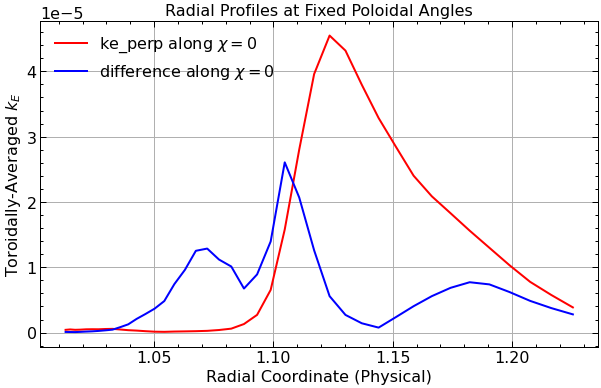

In [32]:
plt.figure(figsize=(10, 6))

plt.plot(rpsi_coord, ke_profile_lfs, label='ke_perp along $\\chi=0$', color='red', linewidth=2)
plt.plot(rpsi_coord, diff_profile_lfs, label='difference along $\\chi=0$', color='blue', linewidth=2)

plt.xlabel('Radial Coordinate (Physical)')
plt.ylabel('Toroidally-Averaged $k_E$')
plt.title('Radial Profiles at Fixed Poloidal Angles')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
chi_coord[0]

array([0.        , 0.00523702, 0.01047183, 0.01570733, 0.02094315,
       0.02617787, 0.03141513, 0.03664982, 0.04188711, 0.04712194,
       0.05235663, 0.05759138, 0.06282762, 0.06806254, 0.07329917,
       0.07853415, 0.08377098, 0.08900575, 0.09424188, 0.09947834,
       0.10471343, 0.10994979, 0.11518458, 0.12041929, 0.12565442,
       0.13088994, 0.13612584, 0.14136192, 0.14659806, 0.15183411,
       0.15706999, 0.16230561, 0.16754096, 0.17277604, 0.17801091,
       0.18324562, 0.18848029, 0.19371506, 0.19895007, 0.20418551,
       0.20942155, 0.21465847, 0.21989509, 0.2251309 , 0.23036601,
       0.23560074, 0.24083546, 0.24607067, 0.25130704, 0.25654357,
       0.26177871, 0.26701339, 0.27224889, 0.27748565, 0.28272054,
       0.28795555, 0.29319256, 0.29842732, 0.30366295, 0.30889845,
       0.31413348, 0.31936935, 0.32460444, 0.32983979, 0.33507564,
       0.34031032, 0.34554622, 0.35078227, 0.35601716, 0.36125187,
       0.36648697, 0.37172256, 0.37695886, 0.38219532, 0.38743

In [65]:
rpsi_coord.shape

(41,)